In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cxr-dataset/reports.csv
/kaggle/input/cxr-dataset/projections.csv
/kaggle/input/cxr-dataset/images/349_IM-1697-2001.dcm.png
/kaggle/input/cxr-dataset/images/607_IM-2196-1001.dcm.png
/kaggle/input/cxr-dataset/images/2832_IM-1249-2001.dcm.png
/kaggle/input/cxr-dataset/images/699_IM-2263-2001.dcm.png
/kaggle/input/cxr-dataset/images/1931_IM-0602-2001.dcm.png
/kaggle/input/cxr-dataset/images/947_IM-2442-2001.dcm.png
/kaggle/input/cxr-dataset/images/2932_IM-1335-1001.dcm.png
/kaggle/input/cxr-dataset/images/2303_IM-0882-1001.dcm.png
/kaggle/input/cxr-dataset/images/291_IM-1313-2001.dcm.png
/kaggle/input/cxr-dataset/images/1790_IM-0515-1001.dcm.png
/kaggle/input/cxr-dataset/images/3489_IM-1696-2001.dcm.png
/kaggle/input/cxr-dataset/images/3275_IM-1556-1002001.dcm.png
/kaggle/input/cxr-dataset/images/286_IM-1267-3001.dcm.png
/kaggle/input/cxr-dataset/images/3071_IM-1433-1001.dcm.png
/kaggle/input/cxr-dataset/images/1991_IM-0648-1001.dcm.png
/kaggle/input/cxr-dataset/images/3083_

In [2]:
import pandas as pd
import numpy as np
import os
import tqdm
import nltk

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from torchvision import models
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [3]:
BEST_CHECKPOINT_PATH = "/kaggle/input/cxr-dataset/epoch_2"
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')

In [4]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768
nltk.download('punkt')
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/input/cxr-dataset/epoch_2/gpt-2-model')
    tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/input/cxr-dataset/epoch_2/gpt-2-tokenizer')
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load('/kaggle/input/cxr-dataset/epoch_2/projection_model.pth'))
    
    vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [6]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:06<00:00, 18.6MB/s]


In [7]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [8]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [9]:
def compare_report(uid):
    print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths)>1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)
    generated_report = generate_report(image_paths)
    print("Generated Report:", generated_report)

In [10]:
reports_df = pd.read_csv('/kaggle/input/cxr-dataset/reports.csv')
projections_df = pd.read_csv('/kaggle/input/cxr-dataset/projections.csv')
img_base_dir = '/kaggle/input/cxr-dataset/images'
uids = projections_df.uid.unique()
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5+1
BATCH_SIZE = 4
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

Patient UID: 321


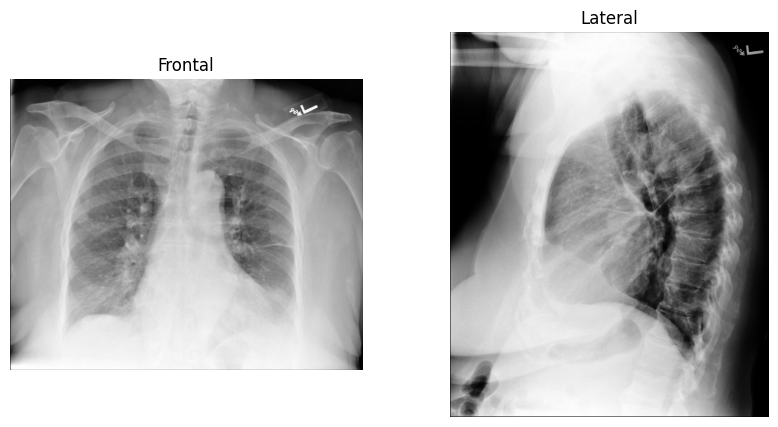

Findings: There are XXXX opacities in the left lung, XXXX subsegmental atelectasis. XXXX opacities overlying the left lung base on the frontal XXXX XXXX reflect epicardial fat XXXX and overlying breast tissue. There is no focal airspace consolidation. No pleural effusion or pneumothorax. Heart size is at the upper limits of normal. There are diffuse degenerative changes of the spine.
Generated Report: 


In [11]:
compare_report(np.random.choice(test_uids))

Patient UID: 3638


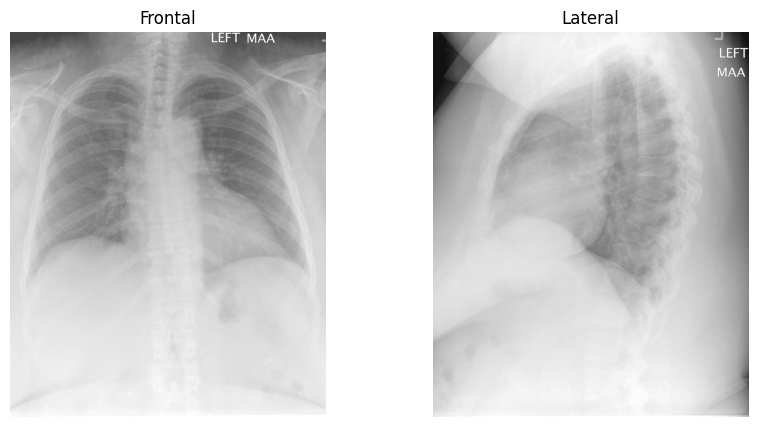

Findings: Cardiomegaly. No pneumothorax or pleural effusion. Clear lung XXXX bilaterally.
Generated Report: c> XXXX XXXX representing the heart size and mediastinal silhouette. The lungs are clear. No pleural effusion or pneumothorax. The XXXX are intact.


In [12]:
compare_report(3638)

Patient UID: 3303


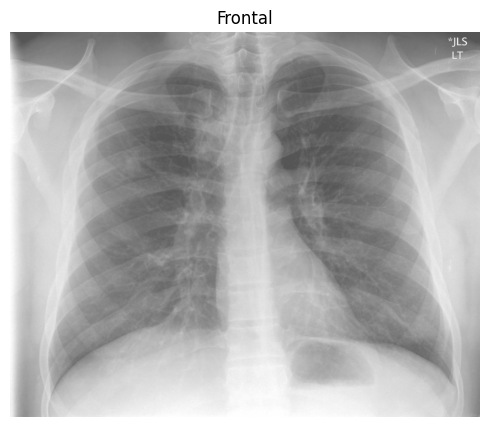

Findings: Heart size and mediastinal contours appear within normal limits. There is a vague 1.6 cm nodular opacity in the right upper lobe between the anterior second and third ribs, which could represent focal infiltrate or lung nodule. No pleural effusion. No pneumothorax. No acute bony abnormality.
Generated Report: c> XXXX XXXX representing the heart size and mediastinal silhouette. The lungs are clear. No pleural effusion or pneumothorax. The XXXX are intact.


In [13]:
compare_report(np.random.choice(test_uids))

Patient UID: 3477


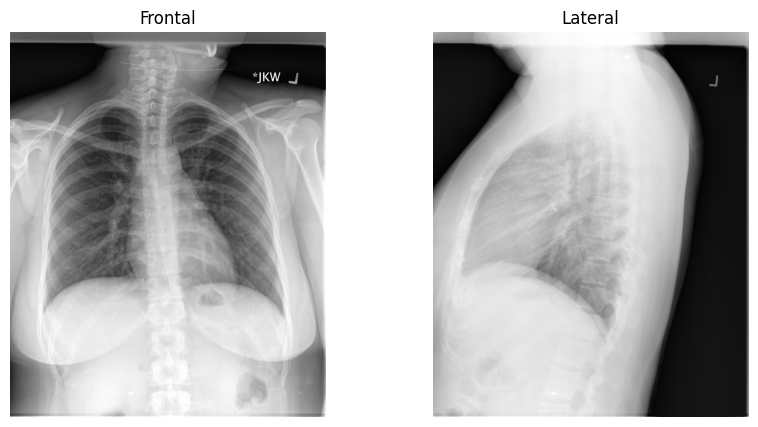

Findings: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. No evidence of active tuberculosis.
Generated Report: t XXXX representing the heart size. The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Negative for acute displaced rib fracture.


In [14]:
compare_report(np.random.choice(test_uids))

Patient UID: 1760


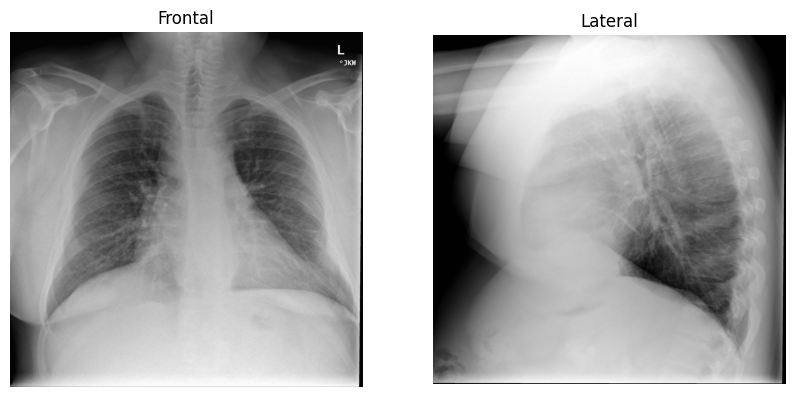

Findings: Mild cardiomegaly. Small area of platelike atelectasis in left mid lung. No pneumothorax or pleural effusion. Soft tissue and bony structures unremarkable.
Generated Report: 


In [15]:
compare_report(np.random.choice(test_uids))

Patient UID: 3220


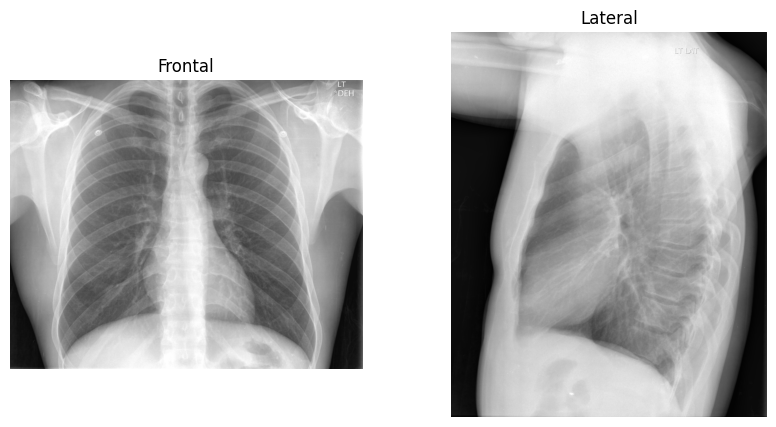

Findings: Lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are within normal limits. Bony structures are intact.
Generated Report: 


In [16]:
compare_report(np.random.choice(test_uids))

Patient UID: 446


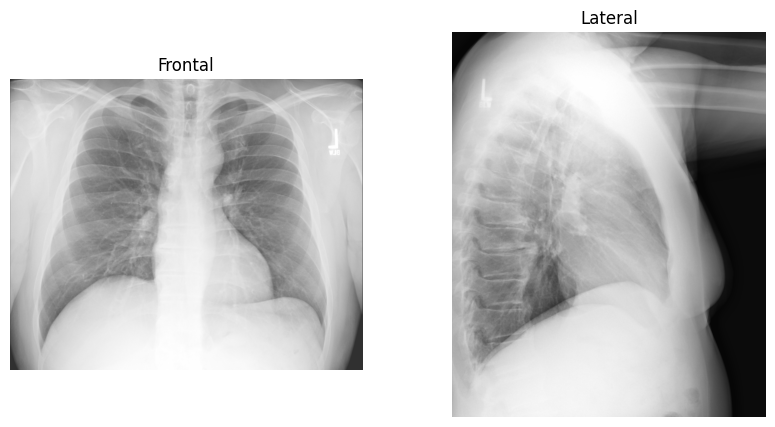

Findings: The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
Generated Report: 


In [17]:
compare_report(np.random.choice(test_uids))

Patient UID: 2518


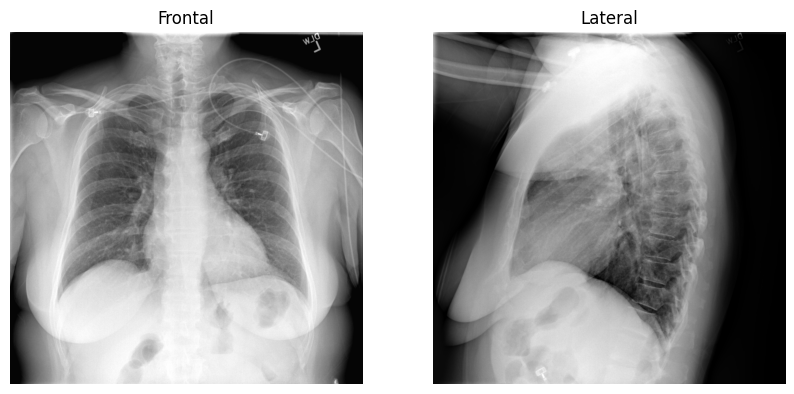

Findings: No The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There are T-spine osteophytes.
Generated Report: The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Negative for acute bone abnormality.


In [18]:
compare_report(np.random.choice(test_uids))


Patient UID: 334


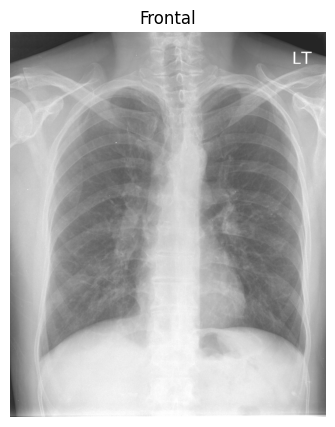

Findings: nan
Generated Report:  XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. Aortic XXXX appear unremarkable. Lungs demonstrate no acute findings. There is no effusion or pneumothorax.


In [19]:
compare_report(np.random.choice(test_uids))

Patient UID: 2099


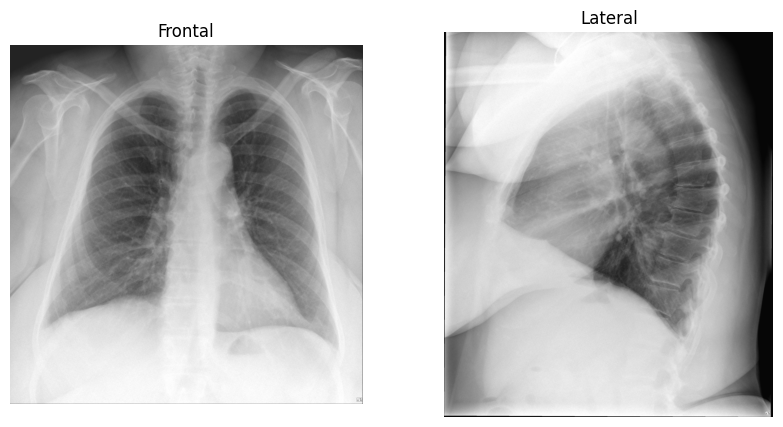

Findings: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
Generated Report: 


In [20]:
compare_report(np.random.choice(test_uids))

Patient UID: 2048


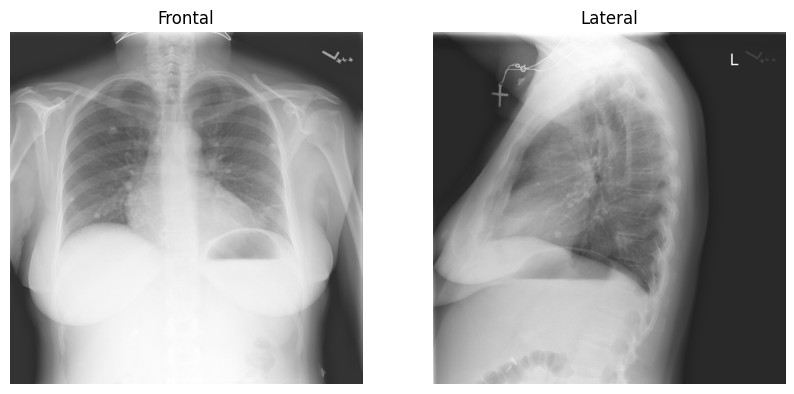

Findings: The lungs and pleural spaces show no acute abnormality. Stable right lower lobe calcified granulomas. Thin XXXX lingular scar, unchanged. Heart size and pulmonary vascularity within normal limits. Surgical clips are visualized in the right upper quadrant.
Generated Report: t XXXX representing a XXXX XXXX representing a chest XXXX. The heart size is normal. The mediastinal contour is within normal limits. No focal consolidation, pleural effusion, or pneumothorax identified. No acute osseous abnormality identified.


In [21]:
compare_report(np.random.choice(test_uids))

Patient UID: 3257


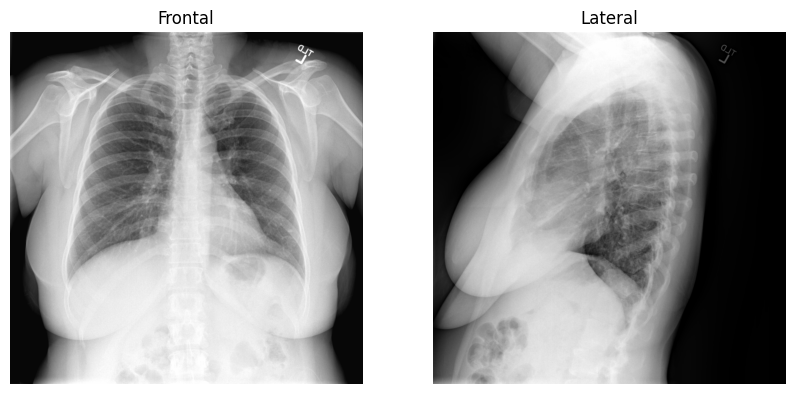

Findings: The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.
Generated Report: 


In [22]:
compare_report(np.random.choice(test_uids))

In [23]:
def calculate_bleu_scores(test_uids):
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    smoothie = SmoothingFunction().method4
    
    for uid in test_uids:
        uid_projection_df = projections_df[projections_df.uid == uid]
        image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
        findings = reports_df[reports_df.uid == uid].findings.iloc[0]
        
        # Ensure findings is a string
        if not isinstance(findings, str):
            print(f"Skipping UID {uid} due to non-string findings.")
            continue
        
        generated_report = generate_report(image_paths)
        
        # Tokenize the findings and generated report
        reference_tokens = [nltk.word_tokenize(findings)]
        generated_tokens = nltk.word_tokenize(generated_report)
        
        # Calculate BLEU scores
        bleu_1 = sentence_bleu(reference_tokens, generated_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu_2 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu_3 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        
        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
    
    avg_bleu_1 = np.mean(bleu_1_scores)
    avg_bleu_2 = np.mean(bleu_2_scores)
    avg_bleu_3 = np.mean(bleu_3_scores)
    
    return avg_bleu_1, avg_bleu_2, avg_bleu_3

# Example usage
test_uids = np.random.choice(test_uids, size=10, replace=False)  # Adjust size as needed
avg_bleu_1, avg_bleu_2, avg_bleu_3 = calculate_bleu_scores(test_uids)
print("Average BLEU-1 Score:", avg_bleu_1)
print("Average BLEU-2 Score:", avg_bleu_2)
print("Average BLEU-3 Score:", avg_bleu_3)

Average BLEU-1 Score: 0.2101091670569386
Average BLEU-2 Score: 0.15834960908219226
Average BLEU-3 Score: 0.13151385545523434


In [24]:
pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import os
import torch
from bert_score import score

# Assuming these are defined somewhere in your script or imported
# img_base_dir = 'path/to/image/directory'
# projections_df = DataFrame containing projections data
# reports_df = DataFrame containing reports data
# test_uids = Array or list of all test UIDs

def calculate_bert_scores(test_uids):
    bert_scores = []

    for uid in test_uids:
        uid_projection_df = projections_df[projections_df.uid == uid]
        image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
        findings = reports_df[reports_df.uid == uid].findings.iloc[0]
        
        # Ensure findings is a string
        if not isinstance(findings, str):
            print(f"Skipping UID {uid} due to non-string findings.")
            continue
        
        generated_report = generate_report(image_paths)
        
        # Calculate BERTScore
        P, R, F1 = score([generated_report], [findings], lang='en', verbose=False)
        bert_scores.append(F1.item())  # F1 is a tensor, convert to float
    
    avg_bert_score = np.mean(bert_scores)
    
    return avg_bert_score

# Example usage
avg_bert_score = calculate_bert_scores(test_uids)
print("Average BERTScore:", avg_bert_score)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average BERTScore: 0.3675421178340912
